In [1]:
import sys
import os
sys.path.append('../dags')

from database import create_database_engine


# 환경 변수 설정
os.environ["POSTGRES_USER"] = "airflow"
os.environ["POSTGRES_PASSWORD"] = "airflow"
os.environ["POSTGRES_DB"] = "events"
os.environ["POSTGRES_PORT"] = "5433"

engine = create_database_engine(host="127.0.0.1")
print("Successfully connected to the database")

Successfully connected to the database


In [2]:
import pandas as pd
from datetime import datetime

# 나머지는 변수로 관리
label_table = "kind"
return_table = "abnormal_return_kind"
label_col = "label"

abn_return_cols = [f"abn_ret_{m}m" for m in range(1, 61)]
volume_cols = [
    "cum_volume_60m", "cum_volume_minus_60m", 
]

# SQL 컬럼 문자열을 만듬 (event_id, event_ts는 하드코딩)
sql_columns = (
    [f"ar.event_ts"] +
    [f"ar.{col}" for col in abn_return_cols] +
    [f"ar.{col}" for col in volume_cols] +
    [f"k.{label_col}"]
)
sql_columns_str = ",\n    ".join(sql_columns)

query = f"""
SELECT {sql_columns_str}
FROM {return_table} ar
JOIN "{label_table}" k ON ar.event_id = k.id
ORDER BY ar.event_ts ASC
"""

df_total = pd.read_sql(query, engine)
df_total["telegram_dummy"] = (
    pd.to_datetime(df_total["event_ts"], utc=True) > pd.Timestamp("2022-06-30", tz="UTC")
).astype(int)
df_total

DETAIL:  The database was created using collation version 2.36, but the operating system provides version 2.41.
HINT:  Rebuild all objects in this database that use the default collation and run ALTER DATABASE events REFRESH COLLATION VERSION, or build PostgreSQL with the right library version.


,event_ts,abn_ret_1m,abn_ret_2m,abn_ret_3m,abn_ret_4m,abn_ret_5m,abn_ret_6m,abn_ret_7m,abn_ret_8m,abn_ret_9m,...,abn_ret_55m,abn_ret_56m,abn_ret_57m,abn_ret_58m,abn_ret_59m,abn_ret_60m,cum_volume_60m,cum_volume_minus_60m,label,telegram_dummy
0,2021-01-04 10:08:00+00:00,0.75,-0.35,-0.18,0.19,-0.20,-0.23,-0.24,-0.67,-0.34,...,0.22,0.02,0.25,0.22,0.28,0.18,109293.0,37913.0,0,0
1,2021-01-04 10:08:00+00:00,0.75,-0.35,-0.18,0.19,-0.20,-0.23,-0.24,-0.67,-0.34,...,0.22,0.02,0.25,0.22,0.28,0.18,109293.0,37913.0,0,0
2,2021-01-04 10:08:00+00:00,-0.07,-0.32,-2.66,-2.49,-2.27,-1.24,-1.62,-1.37,-1.04,...,-0.54,-0.54,-0.99,-1.02,-0.38,-0.95,106830.0,34208.0,1,0
3,2021-01-04 10:14:00+00:00,0.10,-0.13,-2.60,-4.00,-3.64,-3.51,-3.64,-4.17,-4.70,...,-6.36,-6.23,-6.47,-6.43,-6.43,-6.00,1389208.0,200844.0,1,0
4,2021-01-04 10:16:00+00:00,0.46,0.47,0.25,0.19,0.06,-0.24,-0.06,-0.24,-0.50,...,-1.38,-1.34,-1.44,-1.48,-1.48,-1.83,316213.0,213376.0,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8651,2023-12-28 14:46:00+00:00,3.30,9.04,9.00,13.65,7.01,7.60,7.93,7.26,7.78,...,NaN,NaN,NaN,NaN,NaN,NaN,159431.0,7984.0,1,1
8652,2023-12-28 14:53:00+00:00,0.67,-0.64,0.24,0.29,0.21,0.21,0.23,0.27,0.27,...,NaN,NaN,NaN,NaN,NaN,NaN,34468.0,63986.0,1,1
8653,2023-12-28 14:56:00+00:00,-0.01,0.42,0.42,0.44,0.48,0.48,0.45,0.45,0.42,...,NaN,NaN,NaN,NaN,NaN,NaN,23002.0,10049.0,0,1
8654,2023-12-28 14:56:00+00:00,-0.01,0.42,0.42,0.44,0.48,0.48,0.45,0.45,0.42,...,NaN,NaN,NaN,NaN,NaN,NaN,23002.0,10049.0,0,1


In [3]:
df_total = df_total.dropna()

print(df_total.shape[0])

6267


In [4]:
import numpy as np

for m in [60]:
    denom = 1 + df_total[f"cum_volume_minus_{m}m"]
    num = 1 + df_total[f"cum_volume_{m}m"]
    df_total[f"delta_cum_volume_{m}m"] = np.log(num / denom)

for m in [60]:
    col = f"delta_cum_volume_{m}m"
    x = df_total[col].values
    x_min = np.nanmin(x)
    x_max = np.nanmax(x)
    df_total[col] = 2 * (x - x_min) / (x_max - x_min) - 1

# 누적 거래량으로 시작하는 컬럼 모두 drop
cum_cols_to_drop = [col for col in df_total.columns if col.startswith("cum_volume_")]
df_total = df_total.drop(columns=cum_cols_to_drop)
df_total.filter(regex="^delta_cum_").head()


/var/folders/5r/tdks4c2x5vgdpqkw390mgzqm0000gn/T/ipykernel_51364/1078650966.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total[f"delta_cum_volume_{m}m"] = np.log(num / denom)
/var/folders/5r/tdks4c2x5vgdpqkw390mgzqm0000gn/T/ipykernel_51364/1078650966.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total[col] = 2 * (x - x_min) / (x_max - x_min) - 1


,delta_cum_volume_60m
0,-0.361902
1,-0.361902
2,-0.349201
3,-0.223010
4,-0.467489


In [5]:
df_total.filter(regex="^delta_cum_").describe()


,delta_cum_volume_60m
count,6267.000000
mean,-0.417033
std,0.172006
min,-1.000000
25%,-0.526614
50%,-0.440752
75%,-0.333994
max,1.000000


In [6]:
positive_df = df_total[df_total["label"] == 1]
positive_df["time_to_peak"] = positive_df[abn_return_cols].idxmax(axis=1).str.extract(r'(\d+)').astype(int)

negative_df = df_total[df_total["label"] == -1]
negative_df["time_to_peak"] = negative_df[abn_return_cols].idxmin(axis=1).str.extract(r'(\d+)').astype(int)

/var/folders/5r/tdks4c2x5vgdpqkw390mgzqm0000gn/T/ipykernel_51364/2394544948.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_df["time_to_peak"] = positive_df[abn_return_cols].idxmax(axis=1).str.extract(r'(\d+)').astype(int)
/var/folders/5r/tdks4c2x5vgdpqkw390mgzqm0000gn/T/ipykernel_51364/2394544948.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_df["time_to_peak"] = negative_df[abn_return_cols].idxmin(axis=1).str.extract(r'(\d+)').astype(int)


In [7]:
positive_df

,event_ts,abn_ret_1m,abn_ret_2m,abn_ret_3m,abn_ret_4m,abn_ret_5m,abn_ret_6m,abn_ret_7m,abn_ret_8m,abn_ret_9m,...,abn_ret_55m,abn_ret_56m,abn_ret_57m,abn_ret_58m,abn_ret_59m,abn_ret_60m,label,telegram_dummy,delta_cum_volume_60m,time_to_peak
2,2021-01-04 10:08:00+00:00,-0.07,-0.32,-2.66,-2.49,-2.27,-1.24,-1.62,-1.37,-1.04,...,-0.54,-0.54,-0.99,-1.02,-0.38,-0.95,1,0,-0.349201,1
3,2021-01-04 10:14:00+00:00,0.10,-0.13,-2.60,-4.00,-3.64,-3.51,-3.64,-4.17,-4.70,...,-6.36,-6.23,-6.47,-6.43,-6.43,-6.00,1,0,-0.223010,1
13,2021-01-05 10:54:00+00:00,-0.05,-0.02,-0.10,-0.10,-0.19,-0.24,-0.07,-0.11,-0.07,...,-0.40,-0.34,-0.38,-0.40,-0.38,-0.43,1,0,-0.644662,10
15,2021-01-05 11:08:00+00:00,-0.16,0.25,-0.51,-0.51,-0.10,-0.89,-0.95,-0.92,-0.58,...,-0.97,-0.94,-0.59,-0.94,-1.04,-1.07,1,0,-0.616194,2
17,2021-01-05 11:42:00+00:00,0.45,0.04,0.23,0.23,0.42,0.20,-0.06,0.14,0.10,...,-0.22,-0.04,-0.04,0.00,-0.17,0.05,1,0,-0.597064,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8636,2023-12-27 13:51:00+00:00,-1.83,-1.06,-1.78,-1.83,-2.19,-2.27,-2.17,-2.17,-2.16,...,-2.13,-2.13,-2.07,-2.03,-2.11,-2.50,1,1,-0.498931,2
8637,2023-12-27 13:53:00+00:00,-1.84,-1.90,-1.58,-1.99,-1.95,-1.95,-1.37,-1.82,-1.39,...,-2.08,-2.04,-2.17,-2.17,-2.19,-2.30,1,1,-0.368815,11
8643,2023-12-28 09:25:00+00:00,0.39,0.38,0.15,0.16,0.13,0.32,0.88,1.31,1.29,...,1.33,1.17,1.33,1.33,1.30,1.27,1,1,-0.250948,34
8644,2023-12-28 10:40:00+00:00,0.25,-0.11,-0.46,-1.48,-1.23,-1.74,-1.92,-1.99,-2.18,...,-0.28,-0.66,-0.70,-0.37,-0.37,-0.37,1,1,-0.386695,1


In [8]:
negative_df

,event_ts,abn_ret_1m,abn_ret_2m,abn_ret_3m,abn_ret_4m,abn_ret_5m,abn_ret_6m,abn_ret_7m,abn_ret_8m,abn_ret_9m,...,abn_ret_55m,abn_ret_56m,abn_ret_57m,abn_ret_58m,abn_ret_59m,abn_ret_60m,label,telegram_dummy,delta_cum_volume_60m,time_to_peak
4,2021-01-04 10:16:00+00:00,0.46,0.47,0.25,0.19,0.06,-0.24,-0.06,-0.24,-0.50,...,-1.38,-1.34,-1.44,-1.48,-1.48,-1.83,-1,0,-0.467489,60
28,2021-01-07 14:13:00+00:00,-0.07,-0.20,-0.23,-0.23,-0.26,-0.23,0.20,0.23,-0.13,...,0.47,-0.03,-0.06,-0.16,0.27,-0.22,-1,0,-0.441414,36
156,2021-01-25 10:36:00+00:00,0.00,-0.03,-4.57,-4.22,-4.49,-5.40,-4.98,-3.10,-4.42,...,-2.27,-2.87,-3.08,-3.14,-3.32,-3.17,-1,0,-0.204324,6
158,2021-01-25 10:53:00+00:00,0.68,0.38,0.03,0.01,-0.05,0.27,0.18,0.15,-0.23,...,-1.12,-1.11,-1.13,-1.14,-1.16,-1.20,-1,0,-0.662076,54
167,2021-01-25 13:47:00+00:00,0.06,0.13,0.13,0.03,-0.03,0.03,0.10,0.10,0.03,...,-0.39,-0.36,-0.36,-0.36,-0.39,-0.49,-1,0,-0.177582,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8312,2023-11-08 14:04:00+00:00,-0.29,-0.13,-0.29,-0.19,-0.19,-0.16,-0.14,-0.30,-0.13,...,0.16,0.42,0.45,0.27,0.35,0.24,-1,1,-0.432877,8
8357,2023-11-16 13:56:00+00:00,-0.55,-0.51,-0.17,-0.19,-0.33,-0.32,-0.50,-0.25,-0.35,...,-0.14,-0.49,-0.45,-0.45,-0.41,-0.45,-1,1,-0.634676,38
8431,2023-12-01 10:46:00+00:00,-2.17,-1.81,-1.42,-1.38,-1.27,-1.23,-1.19,-1.12,-1.08,...,-1.98,-1.95,-2.02,-2.02,-1.98,-2.02,-1,1,-0.714198,32
8504,2023-12-12 14:15:00+00:00,0.02,-0.06,-0.10,-0.13,-0.10,-0.02,-0.02,0.02,-0.15,...,0.42,0.38,0.46,0.42,0.42,0.33,-1,1,-0.456295,9


In [22]:
summary_pos = positive_df[["time_to_peak", "telegram_dummy"]].groupby("telegram_dummy").describe().round(2)


In [23]:
summary_neg = negative_df[["time_to_peak", "telegram_dummy"]].groupby("telegram_dummy").describe().round(2)


In [24]:
df_total_ttp = pd.concat([positive_df, negative_df])
summary_all = df_total_ttp[["time_to_peak", "telegram_dummy"]].groupby("telegram_dummy").describe().round(2)


In [27]:
pd.concat(
    [summary_pos, summary_neg, summary_all],
    keys=["positive", "negative", "total"],
    names=["event_type", "telegram_dummy"]
)

time_to_peak                                        \
                                 count   mean    std  min    25%   50%   75%   
event_type telegram_dummy                                                      
positive   0                    2009.0  20.51  19.81  1.0   2.00  13.0  37.0   
           1                    1683.0  20.19  19.78  1.0   2.00  12.0  38.0   
negative   0                     266.0  32.03  20.01  1.0  12.00  36.0  51.0   
           1                     178.0  29.37  20.59  1.0   8.25  30.0  50.0   
total      0                    2275.0  21.86  20.17  1.0   3.00  15.0  40.0   
           1                    1861.0  21.06  20.03  1.0   3.00  13.0  39.0   

                                 
                            max  
event_type telegram_dummy        
positive   0               60.0  
           1               60.0  
negative   0               60.0  
           1               60.0  
total      0               60.0  
           1               60.0

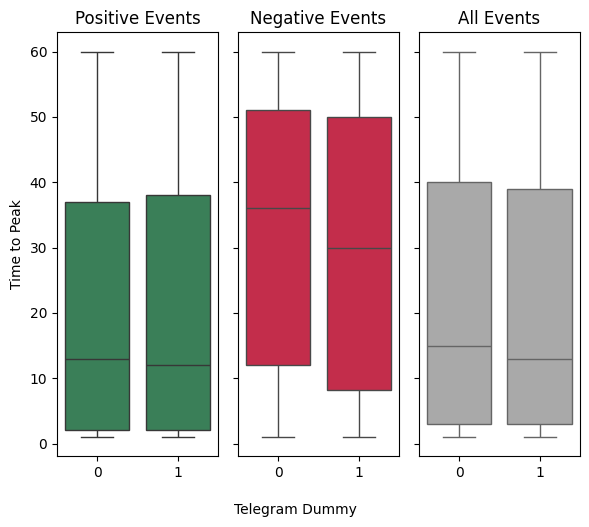

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# 동일 색상 팔레트 사용
colors = ['#2E8B57', '#A9A9A9', '#DC143C']  # 1: positive(초록), 0: neutral(회색), -1: negative(빨강)

# ytick을 세 plot 모두 통일
# 모든 데이터에서 time_to_peak의 min/max를 구하여 yticks 범위 결정
all_time_to_peak = pd.concat([
    positive_df[["time_to_peak"]],
    negative_df[["time_to_peak"]],
    df_total_ttp[["time_to_peak"]]
])["time_to_peak"]

ymin = all_time_to_peak.min()
ymax = all_time_to_peak.max()
# 5단위로 tick 만들기 (적당히, 상황에 맞게 조정)
yticks = list(range(int(ymin) - 1, int(ymax)+1, 10))

fig, axes = plt.subplots(1, 3, figsize=(6, 5), sharey=True)

# Positive: green
sns.boxplot(
    x="telegram_dummy", y="time_to_peak", data=positive_df, ax=axes[0], color=colors[0]
)
axes[0].set_ylabel("Time to Peak")
axes[0].set_title("Positive Events")
axes[0].set_xlabel("")
axes[0].set_yticks(yticks)

# Negative: red
sns.boxplot(
    x="telegram_dummy", y="time_to_peak", data=negative_df, ax=axes[1], color=colors[2]
)
axes[1].set_ylabel("")  # Hide repeated y label
axes[1].set_title("Negative Events")
axes[1].set_xlabel("")
axes[1].set_yticks(yticks)

# All events: 중립(회색) 사용
sns.boxplot(
    x="telegram_dummy", y="time_to_peak", data=df_total_ttp, ax=axes[2], color=colors[1]
)
axes[2].set_ylabel("")  # Hide repeated y label
axes[2].set_title("All Events")
axes[2].set_xlabel("")
axes[2].set_yticks(yticks)

plt.tight_layout()
# 가운데 배치: figure 전체에 텍스트 박스를 수동으로 추가
fig.text(0.5, -0.03, "Telegram Dummy", ha='center', va='center', fontsize=plt.rcParams.get("axes.labelsize", 12))
plt.show()

긍정 이벤트가 반응이 빠르다. 부정이 상대적으로 느림  
부정 이벤트에서 Post_telegram에서 Pre_telegram보다 time-to-peak가 유의미하게 빨라짐

In [13]:
from hypothesis_test_TTP import regress_ln_ttp_with_volume, regress_ttp_with_volume, regress_ln_ttp, regress_ttp

summary = regress_ln_ttp_with_volume(positive_df, volume_col="delta_cum_volume_60m")
summary = regress_ln_ttp_with_volume(negative_df, volume_col="delta_cum_volume_60m")
df_total_ttp = pd.concat([positive_df, negative_df])
summary = regress_ln_ttp_with_volume(df_total_ttp, volume_col="delta_cum_volume_60m")


--- ln(time_to_peak) 회귀 (delta_cum_volume_60m) ---
            variable      coef    std  t_stat  p_value
               const 2.5313*** 0.0540  46.836 0.000000
      telegram_dummy   -0.0252 0.0404  -0.623 0.532971
delta_cum_volume_60m    0.1689 0.1138   1.484 0.137695
R-squared: 0.0007, Adj R-squared: 0.0001, n_obs: 3692

--- ln(time_to_peak) 회귀 (delta_cum_volume_60m) ---
            variable      coef    std  t_stat  p_value
               const 2.9361*** 0.1772  16.569 0.000000
      telegram_dummy   -0.1343 0.1032  -1.302 0.192812
delta_cum_volume_60m   -0.4598 0.3273  -1.405 0.160107
R-squared: 0.0103, Adj R-squared: 0.0058, n_obs: 444

--- ln(time_to_peak) 회귀 (delta_cum_volume_60m) ---
            variable      coef    std  t_stat  p_value
               const 2.5377*** 0.0521  48.691 0.000000
      telegram_dummy   -0.0498 0.0381  -1.305 0.191936
delta_cum_volume_60m   -0.0130 0.1082  -0.120 0.904270
R-squared: 0.0004, Adj R-squared: -0.0001, n_obs: 4136


In [14]:
summary = regress_ttp_with_volume(positive_df, volume_col="delta_cum_volume_60m")
summary = regress_ttp_with_volume(negative_df, volume_col="delta_cum_volume_60m")
summary = regress_ttp_with_volume(df_total_ttp, volume_col="delta_cum_volume_60m")


--- ln(time_to_peak) 회귀 (10m) ---
            variable       coef    std  t_stat  p_value
               const 22.1050*** 0.9066  24.383 0.000000
      telegram_dummy    -0.3635 0.6543  -0.556 0.578526
delta_cum_volume_60m    3.9119* 1.9320   2.025 0.042886
R-squared: 0.0012, Adj R-squared: 0.0007, n_obs: 3692

--- ln(time_to_peak) 회귀 (10m) ---
            variable       coef    std  t_stat  p_value
               const 29.4382*** 3.1735   9.276 0.000000
      telegram_dummy    -2.5187 1.9890  -1.266 0.205395
delta_cum_volume_60m    -5.5129 6.0339  -0.914 0.360899
R-squared: 0.0062, Adj R-squared: 0.0017, n_obs: 444

--- ln(time_to_peak) 회귀 (10m) ---
            variable       coef    std  t_stat  p_value
               const 22.2682*** 0.8789  25.337 0.000000
      telegram_dummy    -0.8062 0.6286  -1.283 0.199624
delta_cum_volume_60m     0.9895 1.8573   0.533 0.594207
R-squared: 0.0005, Adj R-squared: -0.0000, n_obs: 4136


In [15]:
summary = regress_ln_ttp(positive_df)
summary = regress_ln_ttp(negative_df)
summary = regress_ln_ttp(df_total_ttp)


--- ln(time_to_peak) 회귀 (no volume) ---
      variable      coef    std  t_stat  p_value
         const 2.2512*** 0.0323  69.669 0.000000
telegram_dummy   -0.0268 0.0479  -0.560 0.575264
R-squared: 0.0001, Adj R-squared: -0.0002, n_obs: 3692

--- ln(time_to_peak) 회귀 (no volume) ---
      variable      coef    std  t_stat  p_value
         const 3.0555*** 0.0706  43.251  0.00000
telegram_dummy   -0.1613 0.1155  -1.397  0.16246
R-squared: 0.0045, Adj R-squared: 0.0022, n_obs: 444

--- ln(time_to_peak) 회귀 (no volume) ---
      variable      coef    std  t_stat  p_value
         const 2.3453*** 0.0302  77.680 0.000000
telegram_dummy   -0.0568 0.0450  -1.261 0.207311
R-squared: 0.0004, Adj R-squared: 0.0001, n_obs: 4136


In [16]:
summary = regress_ttp(positive_df)
summary = regress_ttp(negative_df)
summary = regress_ttp(df_total_ttp)


--- time_to_peak 회귀 (no volume) ---
      variable       coef   std  t_stat  p_value
         const 20.5117*** 0.442  46.410 0.000000
telegram_dummy    -0.3263 0.654  -0.499 0.617813
R-squared: 0.0001, Adj R-squared: -0.0002, n_obs: 3692

--- time_to_peak 회귀 (no volume) ---
      variable       coef    std  t_stat  p_value
         const 32.0263*** 1.2271  26.100 0.000000
telegram_dummy    -2.6555 1.9711  -1.347 0.177914
R-squared: 0.0041, Adj R-squared: 0.0019, n_obs: 444

--- time_to_peak 회귀 (no volume) ---
      variable       coef    std  t_stat  p_value
         const 21.8580*** 0.4229  51.687 0.000000
telegram_dummy    -0.7941 0.6281  -1.264 0.206127
R-squared: 0.0004, Adj R-squared: 0.0001, n_obs: 4136
